In [59]:
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from math import factorial
from deap.benchmarks.tools import igd
from math import factorial
import warnings
from collections import defaultdict
import random
import tqdm
import geopandas as gpd
import folium


warnings.filterwarnings('ignore')

In [60]:
# Read in the travel times data
travel_times = pd.read_csv('./Travel_Times.csv')

travel_times = travel_times.dropna()


In [61]:
# Create a dictionary to store travel times
travel_times_dict = {(row["Home_LSOA"], row["Site_LSOA"]): row["TT"] for _, row in travel_times.iterrows()}

In [47]:
travel_times[travel_times['Home_LSOA'] == 'E01004801']
travel_times[travel_times['Home_LSOA'] == 'E01025104']


,Home_LSOA,Site_LSOA,TT


In [151]:

#Lets load the other data
sites = pd.read_csv('./Sites.csv', encoding='ISO-8859-1')
activities = pd.read_csv('./CC_Data.csv', encoding='ISO-8859-1')

sites = sites.loc[:, ['UnitCode', 'LSOA','NICU','LCU','SCBU']]
activities_orig = activities.loc[:, ['Der_Postcode_LSOA_Code','CC_Activity_Date','SiteLSOA', 'CC_Level']]
activities = activities.loc[:, ['Der_Postcode_LSOA_Code','CC_Activity_Date','SiteLSOA', 'CC_Level']]

#lets be brutal about this for now.. but we will need to clean our data properly at some point
sites = sites.replace('', np.nan)
sites = sites.dropna()
activities = activities.replace('', np.nan)
activities = activities.dropna()

site_lookup =  sites.loc[:, ['UnitCode', 'LSOA']]

# Ensure the date is a date
activities['CC_Activity_Date'] = pd.to_datetime(activities['CC_Activity_Date'], format='%d/%m/%Y')
home_codes = activities['Der_Postcode_LSOA_Code'].unique().tolist()
activities = activities.set_index('Der_Postcode_LSOA_Code')


#Lets define some useful lists about our data
site_codes = sites['LSOA'].unique().tolist()
site_codes.remove("E01025104")
activity_types = activities['CC_Level'].unique().tolist()

#Lets define the time periods for the analysis
start_date = pd.Timestamp('2021-04-01')
end_date = pd.Timestamp('2022-03-31')
time_periods = pd.date_range(start_date, end_date, freq='D')

filtered_activities = activities.loc[(activities['CC_Activity_Date'] >= start_date) & (activities['CC_Activity_Date'] <= end_date)]

home_lsoas = filtered_activities.index.unique().tolist()
home_level_activities_count = filtered_activities.groupby(["Der_Postcode_LSOA_Code", "CC_Level"]).size().to_dict()
home_activities_count = filtered_activities.groupby(["CC_Activity_Date","Der_Postcode_LSOA_Code"]).size().to_dict()
home_activities_count

activities.head()

,CC_Activity_Date,SiteLSOA,CC_Level
Der_Postcode_LSOA_Code,,,
E01025106,2021-06-13,E01025104,SCBU
E01025106,2021-06-15,E01025104,SCBU
E01025113,2021-05-23,E01025104,SCBU
E01025113,2021-05-25,E01025104,SCBU
E01025113,2021-05-27,E01025104,SCBU


In [143]:
sites

,UnitCode,LSOA,NICU,LCU,SCBU
0,RBL14,E01007251,6,8,10
1,RJR06,E01018377,1,2,10
2,RBT20,E01018480,3,4,8
3,REP01,E01006512,12,12,20
4,RJN71,E01018616,0,1,7
5,RVY38,E01025488,1,1,8
6,RWWWH,E01012457,3,3,12
7,RBN34,E01006499,0,2,13
8,RBS25,E01006570,0,9,0
9,R0A05,E01005062,19,19,31


In [63]:
home_activities_dict = activities.groupby('Der_Postcode_LSOA_Code')['CC_Level'].value_counts().unstack(fill_value=0).to_dict(orient='index')
home_activities_dict

{'E01000065': {'LCU': 0, 'NICU': 0, 'SCBU': 16},
 'E01003610': {'LCU': 0, 'NICU': 0, 'SCBU': 22},
 'E01003613': {'LCU': 0, 'NICU': 0, 'SCBU': 1},
 'E01003952': {'LCU': 0, 'NICU': 0, 'SCBU': 2},
 'E01004770': {'LCU': 0, 'NICU': 0, 'SCBU': 8},
 'E01004775': {'LCU': 0, 'NICU': 3, 'SCBU': 18},
 'E01004779': {'LCU': 1, 'NICU': 0, 'SCBU': 4},
 'E01004780': {'LCU': 3, 'NICU': 2, 'SCBU': 10},
 'E01004781': {'LCU': 1, 'NICU': 0, 'SCBU': 18},
 'E01004787': {'LCU': 0, 'NICU': 0, 'SCBU': 3},
 'E01004794': {'LCU': 1, 'NICU': 1, 'SCBU': 1},
 'E01004795': {'LCU': 1, 'NICU': 0, 'SCBU': 7},
 'E01004797': {'LCU': 0, 'NICU': 0, 'SCBU': 7},
 'E01004801': {'LCU': 0, 'NICU': 0, 'SCBU': 5},
 'E01004802': {'LCU': 0, 'NICU': 0, 'SCBU': 3},
 'E01004804': {'LCU': 0, 'NICU': 0, 'SCBU': 6},
 'E01004806': {'LCU': 0, 'NICU': 2, 'SCBU': 4},
 'E01004809': {'LCU': 0, 'NICU': 0, 'SCBU': 1},
 'E01004810': {'LCU': 0, 'NICU': 0, 'SCBU': 3},
 'E01004811': {'LCU': 0, 'NICU': 0, 'SCBU': 6},
 'E01004812': {'LCU': 0, 'NICU': 0,

In [171]:
# # create a dictionary to map each site to a unique integer
# site_to_int = {site: i for i, site in enumerate(site_codes)}
# int_to_site = {i: site for i, site in enumerate(site_codes)}

# # create a dictionary to map each home to a unique integer
# home_to_int = {home: i for i, home in enumerate(home_lsoas)}
# int_to_home = {i: home for i, home in enumerate(home_lsoas)}

pop_num = 100
cross_chance = 0.5
mutation_prob = 0.2
number_generations = 50


# Number of homes and sites
num_homes = len(home_lsoas)
num_sites = len(site_codes)

activity_to_int = {activity: i for i, activity in enumerate(activities['CC_Level'].unique())}
int_to_activity = {i: activity for i, activity in enumerate(activities['CC_Level'].unique())}

daily_activities = []
for _, daily_df in activities.groupby('CC_Activity_Date'):
    daily_activities.append(daily_df)

# Group by DER_Postcode_LSOA_Code and count the occurrences
home_populations_dict = activities.groupby('Der_Postcode_LSOA_Code').size().to_dict()
home_activities_dict = activities.groupby('Der_Postcode_LSOA_Code')['CC_Level'].value_counts().unstack(fill_value=0).to_dict(orient='index')
home_activities = [[home_activities_dict[home][int_to_activity[i]] for i in range(3)] for home in home_lsoas]


# Convert it to list matching the order of home_lsoas
home_populations = [home_populations_dict[home] for home in home_lsoas]

# For multi-objective: minimize time, maximize assignment to smallest site
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0, 1.0, 1.0)) 
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

toolbox.register("random_site", random.randint, 0, num_sites-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.random_site, num_homes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)




activity_weights = {'LCU': 1.0, 'NICU': 1.0, 'SCBU': 1.0}

# def eval_func(individual):
#     total_time = 0
#     activity_counts = defaultdict(lambda: [0, 0, 0])
#     total_weighted_activity_counts = defaultdict(float)
#     within_30_mins = 0
#     total_population = 0
#     for home_idx, site_idx in enumerate(individual):
#         home = home_lsoas[home_idx]
#         site = site_codes[site_idx]
#         if (home, site) in travel_times_dict:
#             travel_time = travel_times_dict[(home, site)]
#             #print(f"Travel Time: Home {home} to site {site} = {travel_time}")
#             total_time += travel_time * home_populations[home_idx]
#             total_population += home_populations[home_idx]
#             if travel_time <= 30:
#                 within_30_mins += home_populations[home_idx]
#             # Get this home's activity counts
#             activity_counts_per_home = home_activities[home_idx]  
#             for i, activity in enumerate(['LCU', 'NICU', 'SCBU']):
#                 activity_counts[site][i] += activity_counts_per_home[i]
#                 total_weighted_activity_counts[site] += activity_weights[activity] * activity_counts_per_home[i]
#     avg_time = total_time / total_population if total_population != 0 else 0
#     small_site_population = min(sum(ac) for ac in activity_counts.values())
#     max_site_imbalance = max(total_weighted_activity_counts.values()) if total_weighted_activity_counts else 0
#     prop_within_30_mins = within_30_mins / total_population if total_population != 0 else 0
#     sites_over_2000_admissions = sum(1 for activity_count in activity_counts.values() if sum(activity_count) > 2000)
    
#     global logs_df  # Make sure to use the global variable
    
#     # Add a new row to the DataFrame
#     logs_df = logs_df.append({
#         'individual': individual,  # This might be quite large, consider hashing or summarizing instead
#         'avg_time': avg_time,
#         'small_site_population': small_site_population,
#         'prop_within_30_mins': prop_within_30_mins,
#         'sites_over_2000_admissions': sites_over_2000_admissions,
#         'assignments': {home_lsoas[i]: site_codes[individual[i]] for i in range(len(individual))},
#         'max_site_imbalance': max_site_imbalance
#     }, ignore_index=True)
    
#     return avg_time, small_site_population, prop_within_30_mins, sites_over_2000_admissions

logs_df = pd.DataFrame(columns=['individual', 'avg_time', 'prop_within_30_mins', 'sites_over_2000_admissions','assignments'])


# Calculate daily metrics for each activity.
def calculate_daily_metrics(daily_activities_df, individual):
    # Initialize daily metrics.
    daily_time = 0
    daily_within_30_mins = 0
    daily_population = 0
    activity_counts = defaultdict(lambda: [0, 0, 0])  # Count of different activities for each site.
    total_weighted_activity_counts = defaultdict(float)  # Weighted count of activities for each site.
    
    # Prepare daily data
    # Count activities by location and activity level, then restructure the data so it's easily accessible.
    home_activities_dict = daily_activities_df.groupby('Der_Postcode_LSOA_Code')['CC_Level'].value_counts().unstack(fill_value=0).to_dict(orient='index')
    # Create a list of activity counts for each home area.
    home_activities = [[home_activities_dict.get(home, {int_to_activity[i]: 0 for i in range(3)})[int_to_activity[i]] for i in range(3)] for home in home_lsoas]
    
    # Process each site visited by the individual.
    for home_idx, site_idx in enumerate(individual):
        home = home_lsoas[home_idx]
        site = site_codes[site_idx]
        # Check if travel time data is available for the journey from home to the site.
        if (home, site) in travel_times_dict:
            # Get the travel time.
            travel_time = travel_times_dict[(home, site)]
            # Calculate the total time spent traveling for activities.
            for activity_count in home_activities[home_idx]:
                daily_time += travel_time * activity_count
            # Update the total population count.
            daily_population += home_populations[home_idx]
            # Check if the site can be reached within 30 minutes and update the count if so.
            if travel_time <= 30:
                daily_within_30_mins += home_populations[home_idx]
            # Update activity counts for the site.
            for i, activity in enumerate(['LCU', 'NICU', 'SCBU']):
                activity_counts[site][i] += home_activities[home_idx][i]
                total_weighted_activity_counts[site] += activity_weights[activity] * home_activities[home_idx][i]

    # Calculate daily metrics.
    daily_avg_time = daily_time / daily_population if daily_population != 0 else 0
    daily_prop_within_30_mins = daily_within_30_mins / daily_population if daily_population != 0 else 0
    daily_max_site_imbalance = max(total_weighted_activity_counts.values()) if total_weighted_activity_counts else 0

    return daily_avg_time, daily_population, daily_prop_within_30_mins, activity_counts, daily_max_site_imbalance

# Update total metrics with the results from a single day.
def update_total_metrics(daily_metrics, total_activity_counts):
    # Initialize total metrics.
    total_max_site_imbalance, total_time, total_population, total_within_30_mins = 0, 0, 0, 0
    # Extract metrics for the day.
    daily_avg_time, daily_population, daily_prop_within_30_mins, activity_counts, daily_max_site_imbalance = daily_metrics

    # Update total metrics.
    total_time += daily_avg_time
    total_population += daily_population
    total_within_30_mins += daily_prop_within_30_mins
    #total_max_site_imbalance += daily_max_site_imbalance

    # Update total activity counts.
    for site, activity_count in activity_counts.items():
        total_activity_counts[site] += sum(activity_count)

    return total_time, total_population, total_within_30_mins, total_max_site_imbalance

# Evaluation function for a given individual.
def eval_func(individual):
    global logs_df  
    
    # Initialize total metrics and activity counts.
    total_time = 0
    total_population = 0
    total_within_30_mins = 0
    total_max_site_imbalance = 0
    total_activity_counts = defaultdict(int)

    # Process activities for each day.
    for daily_activities_df in daily_activities:
        # Calculate daily metrics.
        daily_metrics = calculate_daily_metrics(daily_activities_df, individual)
        # Update total metrics and activity counts.
        total_time, total_population, total_within_30_mins, total_max_site_imbalance = update_total_metrics(daily_metrics, total_activity_counts)

    # Calculate average metrics over all days.
    avg_time = total_time / len(daily_activities)
    prop_within_30_mins = total_within_30_mins / len(daily_activities)
    avg_max_site_imbalance = total_max_site_imbalance / len(daily_activities)
    
    # Calculate the number of sites with over 2000 admissions.
    sites_over_2000_admissions = sum(1 for activity_count in total_activity_counts.values() if activity_count > 2000)

    # Add a new row to the DataFrame with the results.
    logs_df = logs_df.append({
        'individual': individual,  # This might be quite large, consider hashing or summarizing instead.
        'avg_time': avg_time,
        'prop_within_30_mins': prop_within_30_mins,
        'sites_over_2000_admissions': sites_over_2000_admissions,
        'assignments': {home_lsoas[i]: site_codes[individual[i]] for i in range(len(individual))}
    }, ignore_index=True)

    return avg_time, prop_within_30_mins, sites_over_2000_admissions, avg_max_site_imbalance


toolbox.register("evaluate", eval_func)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=num_sites-1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)


def main():
    random.seed(42)
    pop = toolbox.population(n=pop_num)
    hof = tools.HallOfFame(1)

    # Define statistics for each objective
    stats_time = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    stats_time.register("avg_time", np.mean)

    stats_population = tools.Statistics(key=lambda ind: ind.fitness.values[1])
    stats_population.register("small_site_population", lambda values: values)


    stats_prop = tools.Statistics(key=lambda ind: ind.fitness.values[2])
    stats_prop.register("prop_within_30_mins", np.mean)

    # Define a custom function to count the number of individuals with more than 2000 activities
    def count_large_sites(values):
        return sum(1 for val in values if val > 0)
    
    stats_large_sites = tools.Statistics(key=lambda ind: ind.fitness.values[3])
    stats_large_sites.register("sites_over_2000_admissions", count_large_sites)
    
    # Combine statistics into MultiStatistics
    mstats = tools.MultiStatistics(time=stats_time, population=stats_population, prop=stats_prop, big_sites = stats_large_sites)
    
    # Use mstats instead of the previous stats object
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cross_chance, mutpb=mutation_prob, ngen=number_generations, 
                                   stats=mstats, halloffame=hof, verbose=False)
    
    return pop, log, hof



if __name__ == "__main__":
    pop, log, hof = main()
    #print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    fitnesses = [ind.fitness for ind in pop]
    best_ind_id = fitnesses.index(max(fitnesses))
    best_ind = pop[best_ind_id]
    print(f"Best individual is at index {best_ind_id}: {best_ind}\n with fitness: {best_ind.fitness}")


    # Here we translate the best individual (which is a list of site indices) into a list of (home_code, site_code) pairs
    solution = []
    for i, site_index in enumerate(hof[0]):
        home_code = home_lsoas[i]
        site_code = site_codes[site_index]
        solution.append((home_code, site_code))

    # Now we can create a dictionary that maps each home to a site
    home_to_site_mapping = dict(solution)

    # Now you can print this mapping or use it in further processing
    print("Home to site mapping:")
    print(home_to_site_mapping)

    # Next, let's count the number of activities at each site
    activity_counts = defaultdict(lambda: [0, 0, 0])
    for home_code, site_code in solution:
        activity_counts_per_home = home_activities_dict[home_code]  # get this home's activity counts
        for i in range(3):  # for each type of activity
            activity_counts[site_code][i] += activity_counts_per_home[int_to_activity[i]]


    print("Activity counts per site:")
    print(activity_counts)

    # Initialize the dictionary
    home_to_site_mapping = defaultdict(list)

    # Go through each (home_code, site_code) pair in the solution list
    for home_code, site_code in solution:
        # Add the home code to the list of homes assigned to this site
        home_to_site_mapping[site_code].append(home_code)

    print("Home to site mapping:")
    print(home_to_site_mapping)


KeyboardInterrupt: 

In [172]:
logs_df

,individual,avg_time,prop_within_30_mins,sites_over_2000_admissions,assignments
0,"[20, 3, 0, 8, 7, 7, 4, 3, 17, 2, 18, 13, 1, 0,...",0.000008,0.000185,16,"{'E01025106': 'E01012722', 'E01025113': 'E0100..."
1,"[19, 4, 20, 2, 5, 20, 15, 14, 18, 18, 14, 18, ...",0.000007,0.000198,15,"{'E01025106': 'E01024897', 'E01025113': 'E0101..."
2,"[1, 11, 0, 15, 4, 6, 12, 17, 16, 20, 15, 13, 1...",0.000009,0.000181,17,"{'E01025106': 'E01018377', 'E01025113': 'E0100..."
3,"[3, 12, 1, 13, 8, 17, 8, 4, 5, 18, 8, 0, 10, 1...",0.000005,0.000195,14,"{'E01025106': 'E01006512', 'E01025113': 'E0100..."
4,"[20, 1, 16, 3, 14, 14, 1, 7, 16, 17, 12, 1, 17...",0.000007,0.000152,14,"{'E01025106': 'E01012722', 'E01025113': 'E0101..."
5,"[18, 1, 15, 3, 8, 1, 2, 9, 0, 3, 3, 19, 6, 18,...",0.000006,0.000182,19,"{'E01025106': 'E01025300', 'E01025113': 'E0101..."
6,"[10, 0, 12, 6, 10, 2, 18, 0, 7, 13, 2, 7, 6, 5...",0.000010,0.000192,17,"{'E01025106': 'E01005164', 'E01025113': 'E0100..."
7,"[13, 15, 17, 15, 4, 10, 12, 16, 12, 4, 3, 3, 0...",0.000006,0.000212,15,"{'E01025106': 'E01004880', 'E01025113': 'E0100..."
8,"[13, 10, 18, 4, 6, 8, 4, 13, 17, 6, 9, 9, 2, 9...",0.000010,0.000199,16,"{'E01025106': 'E01004880', 'E01025113': 'E0100..."
9,"[13, 8, 18, 12, 18, 0, 5, 16, 5, 9, 19, 16, 6,...",0.000006,0.000194,15,"{'E01025106': 'E01004880', 'E01025113': 'E0100..."


In [158]:
activity_orders = ['NICU', 'LCU', 'SCBU']

# Initialize a dictionary to hold the capacity usage of each site
capacity_usage = {}

sites_lsoa = sites.loc[:, ['LSOA','NICU','LCU','SCBU']]
sites_lsoa.set_index('LSOA', inplace=True)

# Go through each site in the activity_counts dictionary
for site, counts in activity_counts.items():
    # Get the capacity for this site from the daily_capacity DataFrame
    site_capacity = sites_lsoa.loc[site, activity_orders].values

    # Reorder counts to match the order of site_capacity
    ordered_counts = [counts[activity_orders.index(act)] for act in activity_orders]

    # Calculate the capacity usage for each type of activity
    usage = [count / capacity for count, capacity in zip(ordered_counts, site_capacity)]

    # Add this usage to the capacity_usage dictionary
    capacity_usage[site] = usage
    
capacity_usage

{'E01006570': [inf, 35.888888888888886, inf],
 'E01019155': [inf, inf, 76.0],
 'E01006499': [inf, 137.0, 39.69230769230769],
 'E01024897': [265.3333333333333, 25.5, 20.8],
 'E01005944': [1815.0, 129.66666666666666, 35.44444444444444],
 'E01012722': [1052.0, 124.0, 45.666666666666664],
 'E01018480': [679.3333333333334, 38.5, 61.5],
 'E01006370': [2189.0, 135.0, 73.4],
 'E01004880': [244.33333333333334, 35.285714285714285, 23.842105263157894],
 'E01005164': [971.5, 144.0, 32.333333333333336],
 'E01005070': [849.5, 48.0, 25.6],
 'E01005801': [929.5, 66.33333333333333, 36.083333333333336],
 'E01025488': [1710.0, 259.0, 54.5],
 'E01005354': [204.55555555555554, 22.77777777777778, 16.31578947368421],
 'E01005062': [88.63157894736842, 20.789473684210527, 17.193548387096776],
 'E01012457': [608.0, 109.0, 45.166666666666664],
 'E01007251': [274.0, 16.75, 26.4],
 'E01025300': [337.6666666666667, 35.125, 24.214285714285715],
 'E01018377': [1639.0, 89.0, 35.3],
 'E01018616': [inf, 274.0, 64.857142

In [114]:
lsoas = gpd.read_file('./LSOA_Dec_2011_PWC_in_England_and_Wales/LSOA_Dec_2011_PWC_in_England_and_Wales.shp')

In [137]:
# Make a sites GeoDF
sites_df = lsoas[lsoas['lsoa11cd'].isin(site_codes)]
sites_df = sites_df.set_index('lsoa11cd')
sites_df['centroid'] = sites_df.geometry.centroid

# Make a homes GeoDF
homes_df = lsoas[lsoas['lsoa11cd'].isin(home_codes)]
homes_df = homes_df.set_index('lsoa11cd')
homes_df['centroid'] = homes_df.geometry.centroid

homes_df = homes_df.to_crs(epsg=3857)
sites_df = sites_df.to_crs(epsg=3857)


Failed to get coordinates for home E01025104: 'E01025104'
Failed to get coordinates for home E01007093: 'E01007093'
Failed to get coordinates for home E01006715: 'E01006715'
Failed to get coordinates for home E01006750: 'E01006750'
Failed to get coordinates for home E01007018: 'E01007018'
Failed to get coordinates for home E01006601: 'E01006601'
Failed to get coordinates for home E01004821: 'E01004821'
Failed to get coordinates for home E01006777: 'E01006777'
Failed to get coordinates for home E01006714: 'E01006714'
Failed to get coordinates for home E01006704: 'E01006704'
Failed to get coordinates for home E01006650: 'E01006650'
Failed to get coordinates for home E01006902: 'E01006902'
Failed to get coordinates for home E01006789: 'E01006789'
Failed to get coordinates for home E01006602: 'E01006602'
Failed to get coordinates for home E01025307: 'E01025307'
Failed to get coordinates for home E01006649: 'E01006649'
Failed to get coordinates for home E01006469: 'E01006469'
Failed to get 

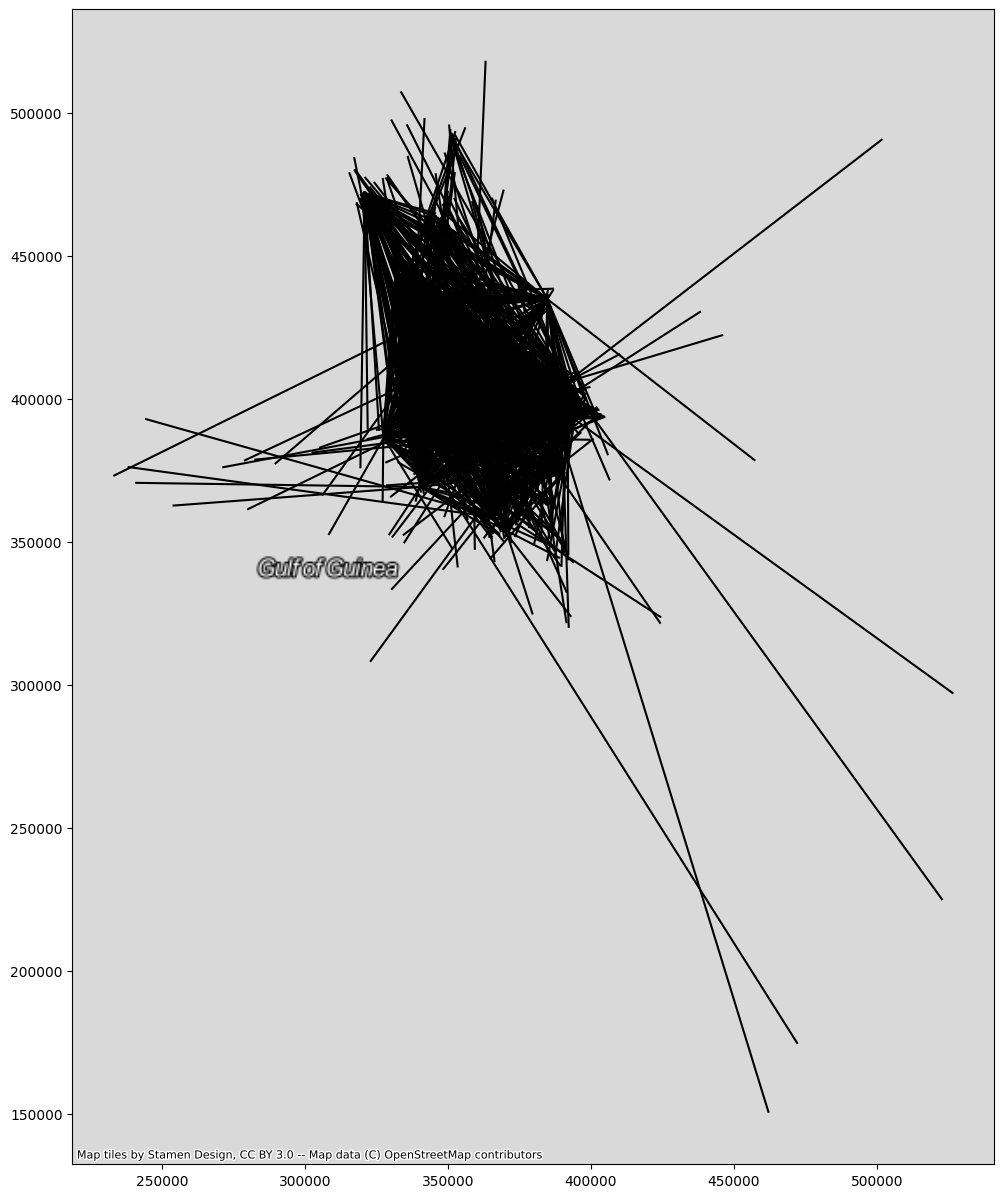

In [142]:
import contextily as ctx

def plot_assignments(individual):

    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot the LSOAs
    homes_df.boundary.plot(ax=ax, color='blue')

    # Plot the sites
    sites_df.boundary.plot(ax=ax, color='red')

    # For each home in the individual, draw a line from the home to the assigned site
    for home_idx, site_idx in enumerate(individual):
        home = home_lsoas[home_idx]
        site = site_codes[site_idx]

        # Try to get the coordinates of the home and the site
        try:
            home_coords = homes_df.loc[home, 'centroid'].coords[0]
        except KeyError as e:
            print(f"Failed to get coordinates for home {home}: {e}")
            continue

        try:
            site_coords = sites_df.loc[site, 'centroid'].coords[0]
        except KeyError as e:
            print(f"Failed to get coordinates for site {site}: {e}")
            continue

        # Draw a line between the home and the site
        plt.plot([home_coords[0], site_coords[0]], [home_coords[1], site_coords[1]], color='black')

    # Add a background map
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

    # Show the plot
    plt.show()


# Use the function
plot_assignments(pop[19])  # Replace with the individual you want to plot


In [136]:
logs_df.describe()

,avg_time,prop_within_30_mins,small_site_population,max_site_imbalance
count,30496.000000,30496.000000,30496.000000,30496.000000
mean,61.607534,0.135203,1602.391494,3231.926285
std,1.294228,0.018055,168.452224,239.402166
min,57.035043,0.078341,771.000000,2608.000000
25%,60.728216,0.122418,1496.000000,3062.000000
50%,61.600755,0.134674,1616.000000,3202.000000
75%,62.476257,0.147233,1722.000000,3368.000000
max,66.622430,0.209926,2072.000000,4690.000000


In [53]:
site_populations

NameError: name 'site_populations' is not defined

In [ ]:
home_activities_dict
home_activities_with_code = home_activities_dict.copy()

# Convert it to a list of tuples
home_activities_list = [(home_code, activities) for home_code, activities in home_activities_with_code.items()]
home_activities_list                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

[('E01000065', {'LCU': 0, 'NICU': 0, 'SCBU': 16}),
 ('E01003610', {'LCU': 0, 'NICU': 0, 'SCBU': 22}),
 ('E01003613', {'LCU': 0, 'NICU': 0, 'SCBU': 1}),
 ('E01003952', {'LCU': 0, 'NICU': 0, 'SCBU': 2}),
 ('E01004770', {'LCU': 0, 'NICU': 0, 'SCBU': 8}),
 ('E01004775', {'LCU': 0, 'NICU': 3, 'SCBU': 18}),
 ('E01004779', {'LCU': 1, 'NICU': 0, 'SCBU': 4}),
 ('E01004780', {'LCU': 3, 'NICU': 2, 'SCBU': 10}),
 ('E01004781', {'LCU': 1, 'NICU': 0, 'SCBU': 18}),
 ('E01004787', {'LCU': 0, 'NICU': 0, 'SCBU': 3}),
 ('E01004794', {'LCU': 1, 'NICU': 1, 'SCBU': 1}),
 ('E01004795', {'LCU': 1, 'NICU': 0, 'SCBU': 7}),
 ('E01004797', {'LCU': 0, 'NICU': 0, 'SCBU': 7}),
 ('E01004801', {'LCU': 0, 'NICU': 0, 'SCBU': 5}),
 ('E01004802', {'LCU': 0, 'NICU': 0, 'SCBU': 3}),
 ('E01004804', {'LCU': 0, 'NICU': 0, 'SCBU': 6}),
 ('E01004806', {'LCU': 0, 'NICU': 2, 'SCBU': 4}),
 ('E01004809', {'LCU': 0, 'NICU': 0, 'SCBU': 1}),
 ('E01004810', {'LCU': 0, 'NICU': 0, 'SCBU': 3}),
 ('E01004811', {'LCU': 0, 'NICU': 0, 'SCBU': 

In [ ]:
import geopandas as gpd
import folium

# Load the LSOA shapefile
lsoas = gpd.read_file('./LSOA_Dec_2011_PWC_in_England_and_Wales/LSOA_Dec_2011_PWC_in_England_and_Wales.shp')

# Convert your mapping to a DataFrame
home_to_site_df = pd.DataFrame.from_dict(home_to_site_mapping, orient='index', columns=['SiteCode'])
home_to_site_df.index.name = 'LSOA_Code'
home_to_site_df.reset_index(inplace=True)

# Merge the shapefile with the DataFrame
merged = lsoas.set_index('LSOA_Code').join(home_to_site_df.set_index('LSOA_Code'))

# Now you can plot the LSOA boundaries and color them by the site they are assigned to
map = folium.Map(location=[latitude, longitude], zoom_start=13)  # set the initial location and zoom level

# Plot each polygon on the map
for _, row in merged.iterrows():
    # Get the shape
    shape = row['geometry']
    # Get the site code
    site_code = row['SiteCode']
    # Create a folium Polygon
    polygon = folium.vector_layers.Polygon(locations=[list(x) for x in shape.exterior.coords],
                                           fill=True,
                                           color='blue' if site_code == 'some_site_code' else 'red')  # just an example
    # Add it to the map
    polygon.add_to(map)

# Display the map
map.save(outfile='map.html')


ValueError: 1 columns passed, passed data had 98 columns